In [1]:
# %pip install sentence-transformers

In [2]:
import pandas as pd
import numpy as np
import os

# Google Library
# from google import genai
# import google.generativeai as genai
# from google.genai import types

import sys
from pydantic import BaseModel
import mimetypes
import json
from timeit import default_timer as timer
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax
import torch
import csv
import urllib.request
import imagehash
import open_clip
import faiss
from PIL import Image
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

/opt/anaconda3/envs/working-env-1/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading the meme jsonl file
with open('data/merged_parsed_results.jsonl', 'r') as f:
    meme_data = [json.loads(line) for line in f]

# Loading meme metadata
meme_metadata = pd.read_parquet('data/meme_submissions.zst.parquet')

In [4]:
print('Number of memes instancesloaded:', len(meme_data))

# Number of non-memes
i = 0
for meme in meme_data:
    try:
        if meme['data']['template'] not in ["NON_MEME", "NO_MEME"]:
            i += 1
    except:
        print(meme['key'])
print('Number of normal memes:', i)

# Filtering out non-memes
meme_data = [meme for meme in meme_data if isinstance(meme['data'], dict)]
meme_data = [meme for meme in meme_data if meme['data'].get('template') not in ["NON_MEME", "NO_MEME"]]
print('Number of memes after filtering NON_MEME:', len(meme_data))

Number of memes instancesloaded: 172573
meme_submissions_1107342
meme_submissions_1044848
Number of normal memes: 171793
Number of memes after filtering NON_MEME: 171793


In [5]:
# === Turn meme_data from an array of jsons into a Dataframe for better visuals ===
from pandas import json_normalize
meme_data_df = pd.DataFrame(meme_data)
meme_data_df = json_normalize(
    meme_data,
    sep="_",
    meta=["key"],
    record_path=None
)

# Remove the leading "_data"
meme_data_df.columns = meme_data_df.columns.str.replace("data_", "", regex=False)
meme_data_df.head()

,key,template,global_context_description,local_context_user_texts,local_context_text_meaning,local_context_instance_specific_image_description,global_context_keywords,local_context_keywords,local_context_global_context_keywords,local_context_local_context_keywords,local_context_made with mematic,local_context_template,local_context_made_with_mematic,local_context_template_modification,local_context_template_text,local_context_watermark,local_context_title,local_context_meme_template_overlay,global_context_thought
0,meme_submissions_1343519,NO_TEMPLATE,"A cat with a loading symbol on its forehead, l...",[Hitler when he saw a blue-eyed Jew],The meme humorously depicts Hitler's supposed ...,,"[cat, loading symbol, confusion, distress, meme]","[Hitler, blue-eyed Jew, confusion, ideology, l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,meme_submissions_134352,I fear no man. But that thing... it scares me.,A three-panel meme format. The first panel sho...,[],The meme humorously depicts a character who cl...,The second panel contains an image of several ...,"[fear, unscared, scared, meme format, character]","[bouncy balls, marbles, fear, irrational fear,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,meme_submissions_1343524,NO_TEMPLATE,A comparison meme showing two fictional creatu...,[],The meme highlights the similarities between t...,,"[comparison, creatures, minecraft, stranger th...","[warden, demogorgon, comparison, similarities,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,meme_submissions_1343526,"Homer Simpson ""Something so stupid""",A four-panel meme format featuring Homer Simps...,"[Increase carbon filtering, produce more wind ...",The meme criticizes the perceived ineffectiven...,,"[Homer Simpson, The Simpsons, stupid action, s...","[carbon filtering, windmills, stupid, species,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,meme_submissions_134353,NO_TEMPLATE,The meme shows a comparison between a house co...,[My house coat in the morning vs my house coat...,The meme humorously exaggerates the difference...,The image is split into two parts. The top tex...,"[house coat, morning, night, comparison, humor...","[house coat, morning, 3am, monster, creepy, co...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## More than half of annotated templates are `NO_TEMPLATE`


Number of 'NO_TEMPLATE' assigned memes: 91958
Number of assigned templates memes: 79835
"NO_TEMPLATE" data contains  53.53% of the entire data after the filter


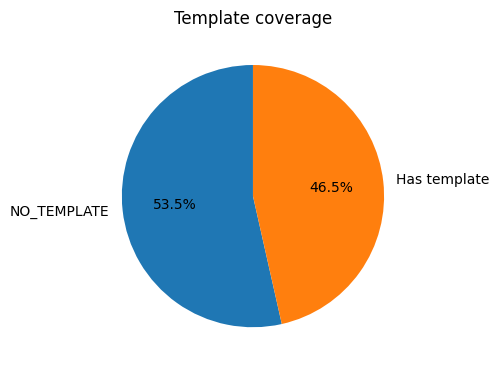

In [6]:
no_template_df = meme_data_df[meme_data_df['template'] == 'NO_TEMPLATE']
template_df = meme_data_df[meme_data_df['template'] != 'NO_TEMPLATE']

# Ratio of memes that were considered NO_TEMPLATE to the entire data
ratio_no_template = no_template_df.shape[0] / meme_data_df.shape[0] * 100
print(f"Number of 'NO_TEMPLATE' assigned memes: {no_template_df.shape[0]}")
print(f"Number of assigned templates memes: {template_df.shape[0]}")
print(f'"NO_TEMPLATE" data contains {ratio_no_template: .2f}% of the entire data after the filter')

# Plot the distribution of templates
sizes = [no_template_df.shape[0], template_df.shape[0]]
labels = ["NO_TEMPLATE", "Has template"]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Template coverage")
plt.tight_layout()
plt.show()
# import matplotlib.pyplot as plt
# tpl_counts = meme_data_df["template"].dropna().value_counts()

# top_k = 20
# top = tpl_counts.head(top_k)

# plt.figure(figsize=(10, 5))
# top.sort_values().plot(kind="barh")
# plt.title(f"Top {top_k} templates")
# plt.xlabel("Count")
# plt.tight_layout()
# plt.show()

## 1. Template Reassignment for `NO_TEMPLATE`

In [ ]:
# Check NO_TEMPLATE to see if it is actually templateless, if not, no problem, but if yes we can assign based on clustering/reference set
img_ids = no_template_df["key"].astype(str).sample(n=10, random_state=42).to_list()

# Perform Binary Search in order to search images with "NO_TEMPLATE"
from pathlib import Path
import bisect
import re
from PIL import Image

folder = Path("Reddit2024_nolabel/images")

# Extract numeric attr for each image's id. 
# e.g.  we extract 1343519 from 'meme_submissions_1343519' 
def extract_num(img_ids):
    return int(img_ids.rsplit("_", 1)[1])


# Build an index from files in folder (supports any extension)
# Example file: meme_submissions_1343519.jpg
id_to_paths = {}
for p in folder.iterdir():
    if not p.is_file():
        continue
    stem = p.stem  # removes extension
    if stem.startswith("meme_submissions_"):
        try:
            n = extract_num(stem)
            id_to_paths.setdefault(n, []).append(p)  # keep all matches
        except ValueError:
            pass

sorted_ids = sorted(id_to_paths.keys())

def bs_find_image_paths(meme_id_str: str):
    q = extract_num(meme_id_str)
    i = bisect.bisect_left(sorted_ids, q)
    if i < len(sorted_ids) and sorted_ids[i] == q:
        return id_to_paths[q]   # list of matching file paths
    return []


# # Print out image path after performing Binary Search
# for id in img_ids:
#     paths = bs_find_image_paths(id)
#     print(id, "->", paths if paths else "Not found")

In [ ]:
from math import ceil

def show_paths(paths, cols=4, figsize_per_row=4):
    if not paths:
        print("No images found.")
        return
    n = len(paths)
    rows = ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * figsize_per_row, rows * figsize_per_row))
    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

    for ax, p in zip(axes, paths):
        img = Image.open(p).convert("RGB")
        ax.imshow(img)
        ax.set_title(p.stem, fontsize=8)
        ax.axis("off")

    for ax in axes[n:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# # dynamic: gather from your keys + lookup
# img_ids = no_template_df["key"].astype(str).str.strip().head(20).tolist()

found_paths = []
missing_ids = []

for k in img_ids:
    paths = bs_find_image_paths(k)   # returns [] or list[Path]
    if paths:
        found_paths.extend(paths)
    else:
        missing_ids.append(k)

print(f"Found: {len(found_paths)} | Missing: {len(missing_ids)}")
if missing_ids:
    print("Missing examples:", missing_ids[:5])

show_paths(found_paths, cols=5)

In [9]:
meme_data_df.columns

Index(['key', 'template', 'global_context_description',
       'local_context_user_texts', 'local_context_text_meaning',
       'local_context_instance_specific_image_description',
       'global_context_keywords', 'local_context_keywords',
       'local_context_global_context_keywords',
       'local_context_local_context_keywords',
       'local_context_made with mematic', 'local_context_template',
       'local_context_made_with_mematic',
       'local_context_template_modification', 'local_context_template_text',
       'local_context_watermark', 'local_context_title',
       'local_context_meme_template_overlay', 'global_context_thought'],
      dtype='object')

### 1.1. Template Reassignment using `Images`
#### Plan
1. **Manually inspect sample images**
   - Review a subset of images from the dataset to validate labeling quality.

2. **Build a reference set from labeled templates**
   - Use images with an existing template label.
   - Compute **CLIP embeddings** and **pHash**.
   - Store results in a separate reference table.

3. **Match `NO_TEMPLATE` images**
   - Compute CLIP embeddings and pHash for each `NO_TEMPLATE` image.
   - Retrieve top candidate matches from the reference set.

4. **Apply decision rules**
   - If `phash_dist <= 6`, assign that template (**high confidence**).
   - Else if `clip_cos >= 0.86` and `(top1 - top2) >= 0.03`, assign that template.
   - Else, keep `NO_TEMPLATE`.


In [ ]:
from pathlib import Path
from PIL import Image
import imagehash
import torch
import open_clip
from tqdm.auto import tqdm

try:
    import faiss
    HAS_FAISS = True
except Exception:
    HAS_FAISS = False

KEY_COL = "key"
LABEL_COL = "template"
NO_TEMPLATE = "NO_TEMPLATE"

# Adjust if needed:
IMAGE_DIR = Path("Reddit2024_nolabel/images")  

# HYPERPARAMS for pHash and CLIP
PHASH_MAX = 6
CLIP_MIN = 0.86
MARGIN_MIN = 0.03
TOPK = 5

In [ ]:
exts = '.jpg'
stem_to_path = {
    p.stem.strip(): p
    for p in IMAGE_DIR.iterdir()
    if p.is_file() and p.suffix.lower() == exts
}

work_df = meme_data_df.copy()
work_df[KEY_COL] = work_df[KEY_COL].astype(str).str.strip()
work_df["image_path"] = work_df[KEY_COL].map(stem_to_path)

print("Total rows:", len(work_df))
print("Rows with image path:", work_df["image_path"].notna().sum())
print("Missing image path:", work_df["image_path"].isna().sum())

In [ ]:
valid_df = work_df[work_df["image_path"].notna()].copy()

known_df = valid_df[valid_df[LABEL_COL] != NO_TEMPLATE].copy()
unknown_df = valid_df[valid_df[LABEL_COL] == NO_TEMPLATE].copy()

print("Known templates:", len(known_df))
print("NO_TEMPLATE:", len(unknown_df))

In [ ]:
device = "mps" if torch.mps.is_available() else "cpu" # "mps" since I use Mac, else "cuda"
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="laion2b_s34b_b79k"
)
model = model.to(device).eval()
print("Device:", device)

In [ ]:
@torch.no_grad()
def clip_embed(path: Path) -> np.ndarray:
    img = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    vec = model.encode_image(img)
    vec = vec / vec.norm(dim=-1, keepdim=True)
    return vec.cpu().numpy().astype("float32")[0]

def phash_val(path: Path):
    return imagehash.phash(Image.open(path).convert("RGB"))

In [ ]:
ref_rows = []
for r in tqdm(known_df.itertuples(index=False), total=len(known_df), desc="Building reference"):
    try:
        p = Path(r.image_path)
        ref_rows.append({
            KEY_COL: getattr(r, KEY_COL),
            LABEL_COL: getattr(r, LABEL_COL),
            "image_path": p,
            "phash": phash_val(p),
            "clip": clip_embed(p),
        })
    except Exception:
        continue

reference_df = pd.DataFrame(ref_rows)
print("Reference rows:", len(reference_df))
reference_df.head(10)

In [ ]:
# Build CLIP Search Index
ref_vecs = np.stack(reference_df["clip"].values).astype("float32")
ref_labels = reference_df[LABEL_COL].values

if HAS_FAISS:
    index = faiss.IndexFlatIP(ref_vecs.shape[1])  # cosine if normalized
    index.add(ref_vecs)
    print("Using FAISS")
else:
    print("FAISS not available, using NumPy fallback")

In [ ]:
def topk_clip(query_vec: np.ndarray, k=TOPK):
    q = query_vec[None, :].astype("float32")
    if HAS_FAISS:
        sims, idxs = index.search(q, k)
        return sims[0], idxs[0]
    sims = ref_vecs @ q[0]  # cosine (normalized vectors)
    idxs = np.argsort(-sims)[:k]
    return sims[idxs], idxs

def assign_template(path: Path):
    # pHash pass
    qh = phash_val(path)
    ph_dists = reference_df["phash"].map(lambda h: qh - h).values
    best_i = int(np.argmin(ph_dists))
    best_ph = int(ph_dists[best_i])
    best_ph_label = reference_df.iloc[best_i][LABEL_COL]

    if best_ph <= PHASH_MAX:
        return {
            "new_template": best_ph_label,
            "match_method": "phash",
            "confidence": 1.0 - best_ph / 64.0,
            "phash_dist": best_ph,
            "clip_top1": np.nan,
            "clip_margin": np.nan,
        }

    # CLIP pass
    qv = clip_embed(path)
    sims, idxs = topk_clip(qv, TOPK)
    top1 = float(sims[0])
    top2 = float(sims[1]) if len(sims) > 1 else -1.0
    margin = top1 - top2
    label1 = reference_df.iloc[int(idxs[0])][LABEL_COL]

    if top1 >= CLIP_MIN and margin >= MARGIN_MIN:
        return {
            "new_template": label1,
            "match_method": "clip",
            "confidence": top1,
            "phash_dist": best_ph,
            "clip_top1": top1,
            "clip_margin": margin,
        }

    return {
        "new_template": NO_TEMPLATE,
        "match_method": "none",
        "confidence": top1,
        "phash_dist": best_ph,
        "clip_top1": top1,
        "clip_margin": margin,
    }

In [ ]:
preds = []
for r in tqdm(unknown_df.itertuples(index=False), total=len(unknown_df), desc="Matching NO_TEMPLATE"):
    try:
        p = Path(r.image_path)
        out = assign_template(p)
        out[KEY_COL] = getattr(r, KEY_COL)
        preds.append(out)
    except Exception:
        preds.append({
            KEY_COL: getattr(r, KEY_COL),
            "new_template": NO_TEMPLATE,
            "match_method": "error",
            "confidence": np.nan,
            "phash_dist": np.nan,
            "clip_top1": np.nan,
            "clip_margin": np.nan,
        })

pred_df = pd.DataFrame(preds)
pred_df.head()

In [ ]:

# MERGE WITH THE ORIGINAL DF COPIED TO GET THE NEW_TEMPLATE
image_reassigned_df = meme_data_df.copy()
tmp = image_reassigned_df.merge(
    pred_df[["key", "new_template"]], 
    on="key",
    how="left"
)

tmp["template"] = tmp["new_template"].combine_first(tmp["template"])


tmp = tmp.drop(columns=["new_template"])

# result
image_reassigned_df_updated = tmp
image_reassigned_df_updated


In [ ]:
# RESULTS AFTER ASSIGNING NEW TEMPLATES
no_template_df = image_reassigned_df_updated[image_reassigned_df_updated['template'] == 'NO_TEMPLATE']
template_df = image_reassigned_df_updated[image_reassigned_df_updated['template'] != 'NO_TEMPLATE']

# Ratio of memes that were considered NO_TEMPLATE to the entire data
ratio_no_template = no_template_df.shape[0] / meme_data_df.shape[0] * 100
print(f"Number of 'NO_TEMPLATE' assigned memes atfer reassigning: {no_template_df.shape[0]}")
print(f"Number of assigned templates memes: {template_df.shape[0]}")
print(f'"NO_TEMPLATE" data contains {ratio_no_template: .2f}% of the entire data after the reassignment')

# Plot the distribution of templates
sizes = [no_template_df.shape[0], template_df.shape[0]]
labels = ["NO_TEMPLATE", "Has template"]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Template coverage")
plt.tight_layout()
plt.show()

### 1.2. Template reassignment using `global context + text + desc`

#### Plan
1. **Build text features**
   - Create `text_for_embed` by concatenating:
     - `global_context_description`
     - `global_context_keywords` (join array into a string)
     - `global_context_thought`

2. **Embed the text**
   - Encode `text_for_embed` for both labeled templates and `NO_TEMPLATE` memes using a sentence embedding model (e.g., `all-mpnet-base-v2`).
   - Normalize embeddings for cosine similarity.

3. **Compute template centroids**
   - Group labeled memes by `template`.
   - Average embeddings within each template to form a centroid vector.

4. **Match `NO_TEMPLATE` to centroids**
   - Compute cosine similarity from each `NO_TEMPLATE` meme to all centroids.
   - Store `top1_sim`, `top2_sim`, and `margin = top1_sim - top2_sim`.

5. **Apply decision rules**
   - If `top1_sim >= SIM_MIN` and `margin >= MARGIN_MIN`, assign `new_template`.
   - Else, keep `NO_TEMPLATE`.


In [ ]:
# BUILD TEXT ROW


KEY_COL = "key"
LABEL_COL = "template"
NO_TEMPLATE = "NO_TEMPLATE"

TEXT_COLS = [
    "global_context_description",
    "global_context_keywords",   # list
    "global_context_thought",
]

def build_text(row):
    parts = []
    for c in TEXT_COLS:
        v = row.get(c, None)

        # handle keyword arrays
        if isinstance(v, list):
            s = " ".join([str(x).strip() for x in v if x is not None and str(x).strip()])
        else:
            if v is None or pd.isna(v):
                continue
            s = str(v).strip()

        if s:
            parts.append(s)

    return " | ".join(parts)

work_df = meme_data_df.copy()
work_df["text_for_embed"] = work_df.apply(build_text, axis=1)
work_df = work_df[work_df["text_for_embed"].str.len() > 0].copy()

print("Rows with usable text:", len(work_df))
print("NO_TEMPLATE rows:", (work_df[LABEL_COL] == NO_TEMPLATE).sum())

In [ ]:
known_df = work_df[work_df[LABEL_COL] != NO_TEMPLATE].copy().reset_index(drop=True)
unknown_df = work_df[work_df[LABEL_COL] == NO_TEMPLATE].copy().reset_index(drop=True)
def fix_template(x):
    if isinstance(x, list):
        return x[0] if len(x) > 0 else None
    return x

# Make sure templates are hashable strings
known_df = known_df.copy()
unknown_df = unknown_df.copy()
known_df[LABEL_COL] = known_df[LABEL_COL].apply(fix_template)
unknown_df[LABEL_COL] = unknown_df[LABEL_COL].apply(fix_template)

print("Known:", len(known_df), "Unknown:", len(unknown_df))


In [ ]:
# Encode text + build templates
model = SentenceTransformer("all-mpnet-base-v2")

# Encode both
known_emb = model.encode(
    known_df["text_for_embed"].tolist(),
    normalize_embeddings=True,
    show_progress_bar=True
)
unknown_emb = model.encode(
    unknown_df["text_for_embed"].tolist(),
    normalize_embeddings=True,
    show_progress_bar=True
)



In [ ]:
grp = known_df.groupby(LABEL_COL).indices  # template -> row indices
templates = []
centroids = []

for t, idxs in grp.items():
    c = known_emb[list(idxs)].mean(axis=0)
    c = c / np.linalg.norm(c)
    templates.append(t)
    centroids.append(c)

centroids = np.vstack(centroids)

In [ ]:
# Match the NO_TEMPLATE by cosine_similarity
sims = cosine_similarity(unknown_emb, centroids)
top1_idx = sims.argmax(axis=1)
top1_sim = sims[np.arange(len(sims)), top1_idx]
top2_sim = np.sort(sims, axis=1)[:, -2] if sims.shape[1] > 1 else np.zeros(len(sims))
margin = top1_sim - top2_sim

unknown_df["new_template"] = [templates[i] for i in top1_idx]
unknown_df["text_sim_top1"] = top1_sim
unknown_df["text_margin"] = margin


# See which threshold is the best
def reassigned_rate(sim_min, margin_min):
    m = (unknown_df["text_sim_top1"] >= sim_min) & (unknown_df["text_margin"] >= margin_min)
    return m.mean(), m.sum()

for sim_min in [0.70, 0.68, 0.66, 0.64, 0.62, 0.60, 0.58]:
    for margin_min in [0.08, 0.06, 0.04, 0.02, 0.00]:
        rate, cnt = reassigned_rate(sim_min, margin_min)
        print(f"SIM_MIN={sim_min:.2f}, MARGIN_MIN={margin_min:.2f} -> reassigned {cnt} ({rate*100:.1f}%)")


plt.figure()
plt.hist(unknown_df["text_sim_top1"], bins=50)
plt.title("Distribution of top-1 cosine similarity (NO_TEMPLATE)")
plt.xlabel("top-1 similarity"); plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(unknown_df["text_margin"], bins=50)
plt.title("Distribution of top-1 margin over top-2 (NO_TEMPLATE)")
plt.xlabel("margin"); plt.ylabel("count")
plt.show()


In [ ]:
# Tune the threshold, static for now
SIM_MIN = 0.68
MARGIN_MIN = 0.04

unknown_df["final_from_text"] = np.where(
    (unknown_df["text_sim_top1"] >= SIM_MIN) & (unknown_df["text_margin"] >= MARGIN_MIN),
    unknown_df["new_template"],
    NO_TEMPLATE
)

In [ ]:
text_reassigned_df_updated = work_df.merge(
    unknown_df[[KEY_COL, "final_from_text", "text_sim_top1", "text_margin"]],
    on=KEY_COL, how="left"
)

text_reassigned_df_updated["final_template"] = np.where(
    text_reassigned_df_updated[LABEL_COL] == NO_TEMPLATE,
    text_reassigned_df_updated["final_from_text"].fillna(NO_TEMPLATE),
    text_reassigned_df_updated[LABEL_COL]
)

no_template_df_text = text_reassigned_df_updated[text_reassigned_df_updated["final_template"] == NO_TEMPLATE]
template_df_text    = text_reassigned_df_updated[text_reassigned_df_updated["final_template"] != NO_TEMPLATE]

ratio_no_template_text = no_template_df_text.shape[0] / text_reassigned_df_updated.shape[0] * 100

print(f"Number of 'NO_TEMPLATE' memes after text reassignment: {no_template_df_text.shape[0]}")
print(f"Number of templated memes after text reassignment: {template_df_text.shape[0]}")
print(f'"NO_TEMPLATE" contains {ratio_no_template_text:.2f}% of the dataset after text reassignment')


sizes = [no_template_df_text.shape[0], template_df_text.shape[0]]
labels = ["NO_TEMPLATE", "Has template"]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Template coverage after text reassignment")
plt.tight_layout()
plt.show()

In [ ]:
# # Save two df to csv to avoid re-runs
# text_reassigned_df_updated.to_csv('data/text_reassigned_memes.csv', index=False)
# image_reassigned_df_updated.to_csv('data/image_reassigned_memes.csv', index=False)


In [ ]:
# 1) merge text-based reassignment as text_template
meme_data_df = meme_data_df.merge(
    text_reassigned_df_updated.rename(columns={"final_template": "text_template"}),
    on="key",
    how="left"
)

# 2) merge image-based reassignment as img_template
meme_data_df = meme_data_df.merge(
    image_reassigned_df_updated.rename(columns={"template": "img_template"}),
    on="key",
    how="left"
)

meme_data_df